In [1]:
import torch
import triton
import torch.nn.functional as F
import sys
sys.path.append('/home/roark/Documents/7_cuda/triton/rk/rk_triton')
sys.path.append('/home/roark/Documents/7_cuda/triton')
from triton_tutorials.layernorm import LayerNorm
from functions.LayerNorm import LayerNormFused

DEVICE = triton.runtime.driver.active.get_active_torch_device()
ln = LayerNormFused.apply
official_ln = LayerNorm.apply

## Test

### test forward

In [2]:
def test_fwd(M, N, dtype=torch.float32, eps=1e-6, device=DEVICE):
    x_shape = (M, N)
    w_shape = (N, )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias   = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    x.requires_grad_(True) # 为了不track上一行x构造式中的-, +, *计算
    # fwd
    triton_y = ln(x, w_shape, weight, bias, eps)
    official_y = official_ln(x, w_shape, weight, bias, eps)
    torch_y = F.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    print(torch.max(torch.abs(torch_y - triton_y)).item())
    print(torch.max(torch.abs(torch_y - official_y)).item())
    assert torch.allclose(torch_y , triton_y , atol=1e-2)
    assert torch.allclose(torch_y , official_y , atol=1e-2)


In [3]:
# torch.manual_seed(0)
# test_fwd(128, 1024, torch.float16)

### test backward

In [4]:
def test_layernorm(M, N, dtype=torch.float32, eps=1e-6, device=DEVICE):
    x_shape = (M, N)
    w_shape = (N, )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias   = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    x.requires_grad_(True) # 为了不track上一行x构造式中的-, +, *计算
    dy = 0.1 * torch.randn_like(x)
    # dy = torch.ones_like(x)
    # fwd
    triton_y = ln(x, w_shape, weight, bias, eps)
    torch_y = F.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    # bwd
    triton_y.backward(dy)
    triton_dx, triton_dw, triton_db = [k.grad.clone() for k in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None
    torch_y.backward(dy)
    torch_dx, torch_dw, torch_db = [k.grad.clone() for k in [x, weight, bias]]
    print(torch.max(torch.abs(torch_y - triton_y)).item())
    print(torch.max(torch.abs(torch_dx - triton_dx)).item())
    print(torch.max(torch.abs(torch_dw - triton_dw)).item())
    print(torch.max(torch.abs(torch_db - triton_db)).item())
    assert torch.allclose(torch_y , triton_y , atol=1e-2)
    assert torch.allclose(torch_dx, triton_dx, atol=1e-2)
    assert torch.allclose(torch_dw, triton_dw, atol=1e-2)
    assert torch.allclose(torch_db, triton_db, atol=1e-2)

In [5]:
torch.manual_seed(0)
test_layernorm(128, 32, torch.float16)

0.0001220703125
0.000244140625
3.0517578125e-05
0.0


In [6]:
torch.manual_seed(0)
shape = (300, 2000)
x = torch.randn(shape, dtype=torch.float32).to(DEVICE)
w = torch.ones(shape[-1]).to(x.dtype).to(DEVICE)
b = torch.zeros(shape[-1]).to(x.dtype).to(DEVICE)
y = ln(x, (shape[-1], ), w, b, )

In [7]:
torch_y = F.layer_norm(x, normalized_shape=(shape[-1],), weight=w, bias=b, eps=1e-8)

In [8]:
print('Max: ', torch.max(torch.abs(y-torch_y)).item())
print('Mean: ', torch.mean(torch.abs(y-torch_y)).item())

error = torch.abs(y - torch_y)
print("Number of exact matches:", (error == 0).sum().item(), "out of", error.numel())
print("Number of not matches:", (error != 0).sum().item(), "out of", error.numel())

assert torch.allclose(y, torch_y, atol=1e-2)

Max:  4.76837158203125e-07
Mean:  3.03031519877095e-08
Number of exact matches: 347549 out of 600000
Number of not matches: 252451 out of 600000


## Benchmark

#### Forward pass

In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg='provider',
        line_vals=['triton', 'torch', 'triton_tutorial'],
        line_names=['Triton', 'Torch', 'Tutorial'],
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'forward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():

        if provider == "triton_tutorial":
            return official_ln(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "triton":
            return ln(x, w_shape, weight, bias, eps)

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
    
# bench_layer_norm.run(save_path='.', print_data=False)

#### Backward pass

In [15]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 40, 2)],
        # x_vals=[2 ** i for i in range(10, 16)],
        line_arg='provider',
        line_vals=['triton', 'torch', 'triton_tutorial'],
        line_names=['Triton', 'Torch', 'Tutorial'],
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'backward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():
        if provider == "triton_tutorial":
            return official_ln(x, w_shape, weight, bias, eps)  # noqa: F811, E704
        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704
        if provider == "triton":
            return ln(x, w_shape, weight, bias, eps)

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

layer-norm-backward:
          N      Triton       Torch    Tutorial
0    1024.0   61.962812  225.986210   39.948795
1    2048.0   76.348913  429.040919   80.137772
2    3072.0  113.876624  475.185512  115.532833
3    4096.0  151.084389  437.636073  159.204823
4    5120.0  188.258721  416.763121  198.103678
5    6144.0  226.105325  395.208510  239.376633
6    7168.0  265.558321  391.301414  280.039892
7    8192.0  303.509869  380.631388  317.005821
8    9216.0  549.120456  380.674873  531.492674
9   10240.0  592.862432  368.041921  397.951623
10  11264.0  413.871967  361.668641  438.501231
11  12288.0  450.419258  354.261952  474.123119
12  13312.0  490.670776  354.138219  519.123375
13  14336.0  527.048748  347.676569  542.366872
14  15360.0  556.057436  345.709717  561.509868
15  16384.0  572.158608  340.097086  608.458052
16  17408.0  221.752443  341.246219   30.892528
17  18432.0  229.805284  339.137661   32.463243
18  19456.0  235.321482  339.025465   34.295661


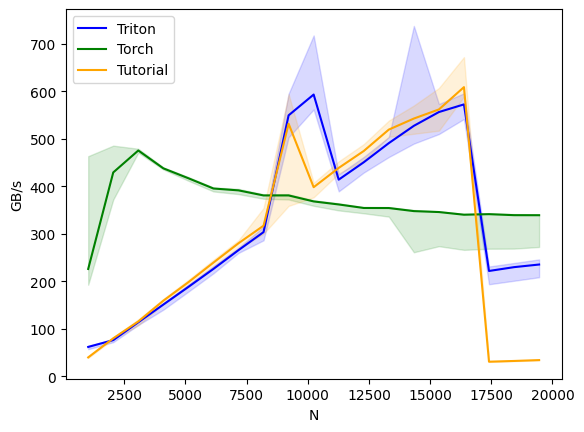

: 

In [ ]:
bench_layer_norm.run(save_path='.', print_data=True)
# 最大可支持N=16384，超过后报错，所以下面performance下降并不是真的性能下降，而是程序报错